In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Load the 'business' dataset

In [15]:
df2 = pd.read_json("yelp_academic_dataset_business.json", chunksize = 1000, lines = True)
drop_cols = ['address', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open','attributes', 'hours']

* Deleting non useful columns

In [16]:
import time
start = time.time()
chunks = []
a = 0
for chunk in df2:
    a += 1
    chunk_b = chunk.drop(drop_cols, axis = 1)
    restas = chunk_b[chunk_b['categories'].str.contains('restaurant', case = False, na = False)]
    chunks.append(restas)
restaurants = pd.concat(chunks, ignore_index= True, join='outer')
end = time.time()
elapsed = end-start

In [17]:
restaurants.shape

(63961, 4)

## Load the reviews dataset
* Remember we made the merge to use ONLY restaurants data, because there were data from other things

In [18]:
reviews_raw = pd.read_json("yelp_academic_dataset_review.json", chunksize=100000, lines = True)
drop_cols = ['review_id', 'user_id','useful', 'funny', 'cool', 'date']

* Using merge instead of join because we want to join in another column other than the index

In [19]:
a = 0
for chunk in reviews_raw:
    a += 1
    reviews = chunk.drop(drop_cols, axis = 1)
    data = restaurants.merge(reviews, left_on = 'business_id', right_on = 'business_id',how = 'inner')
    if a == 1:
        break

### Finally the data to be preprocessed (the "text" column, to be exact) 
TBD:
* Delete all number 3 i.e neutral 
* Same number of positive as negatives
* Shuffle the data

In [20]:
data.head()

,business_id,name,city,categories,stars,text
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,"Ethnic Food, Food Trucks, Specialty Food, Impo...",5,I love the empanadas from the Empanadas House!...
1,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,"Definitely under new management, and the dinin..."
2,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,I will also agree that this place has great fo...
3,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,Thornhill,"Japanese, Fast Food, Food Court, Restaurants",4,Been coming here since I was in grade 9 so abo...
4,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",5,Love Wetzel's pretzels! I always get them when...


## Get a toyset to work in trials from here

In [27]:
data2 = data.loc[0:99, ['name', 'stars', 'text']]
data2.head()

,name,stars,text
0,The Empanadas House,5,I love the empanadas from the Empanadas House!...
1,Middle East Deli,3,"Definitely under new management, and the dinin..."
2,Middle East Deli,3,I will also agree that this place has great fo...
3,Banzai Sushi,4,Been coming here since I was in grade 9 so abo...
4,Wetzel's Pretzels,5,Love Wetzel's pretzels! I always get them when...


* Some graphs to know the number of reviews by ranking

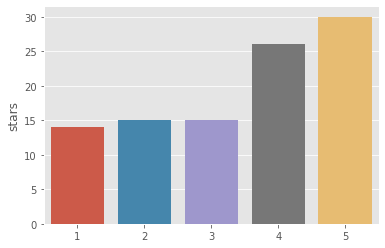

In [22]:
bars = data2['stars'].value_counts()
sns.barplot(x = bars.index, y = bars)

* Delete the number 3's

In [23]:
data2.drop(data2[data2['stars'] == 3].index, inplace = True)
data2 = data2.reset_index(drop = True)

* We want just the reviews with 4-5 to be positive and the 1-2 to be negative, we do that on the following

In [29]:
data2['Sentiment'] = data2['stars'].apply(lambda x: 1 if x > 3 else 0)

In [30]:
data2.dtypes

name         object
stars         int64
text         object
Sentiment     int64
dtype: object

In [31]:
data2['Sentiment'].value_counts()

1    56
0    44
Name: Sentiment, dtype: int64

In [67]:
print(data2['text'][0:50])

0     I love the empanadas from the Empanadas House!...
1     Definitely under new management, and the dinin...
2     I will also agree that this place has great fo...
3     Been coming here since I was in grade 9 so abo...
4     Love Wetzel's pretzels! I always get them when...
5     So why would I be giving a Fast Food chain loc...
6     I come here bout 3x's a mo. & I just can't do ...
7     We've eaten here a few times now, and have bee...
8     This place used to be called Chicken Bonz, as ...
9     Good food, terrible customer service.  For me ...
10    Just another nice Amir food nothing more but r...
11    Small portions and expensive. There was so lit...
12    I only ever eat at three of the millions of Am...
13    We just recently discovered this place and I j...
14    I can't believe I never knew about a place tha...
15    The one thing keeping this place from getting ...
16    We've tried a few different Chinese delivery p...
17    My expectations of chinese delivery places

## From here start the NLP pipeline

The goal here is to make a bag of words, it can be done manually, but also with sklearn.

**Steps:** I am trying to extract the nest tokens with the tokenizer from Potts and then feed that already "clean tokens" to the vectorizer

In [176]:
raw = data2['text'][1:3]
raw
raw2 = data2['text'][1]

In [177]:
raw

1    Definitely under new management, and the dinin...
2    I will also agree that this place has great fo...
Name: text, dtype: object

In [178]:
from nltk.probability import FreqDist
counter = FreqDist()
help(FreqDist)

Help on class FreqDist in module nltk.probability:

class FreqDist(collections.Counter)
 |  FreqDist(samples=None)
 |  
 |  A frequency distribution for the outcomes of an experiment.  A
 |  frequency distribution records the number of times each outcome of
 |  an experiment has occurred.  For example, a frequency distribution
 |  could be used to record the frequency of each word type in a
 |  document.  Formally, a frequency distribution can be defined as a
 |  function mapping from each sample to the number of times that
 |  sample occurred as an outcome.
 |  
 |  Frequency distributions are generally constructed by running a
 |  number of experiments, and incrementing the count for a sample
 |  every time it is an outcome of an experiment.  For example, the
 |  following code will produce a frequency distribution that encodes
 |  how often each word occurs in a text:
 |  
 |      >>> from nltk.tokenize import word_tokenize
 |      >>> from nltk.probability import FreqDist
 |      >

In [172]:
fdist.N

<bound method FreqDist.N of FreqDist({})>

In [242]:
tokenizer = []
a = 0
for i in raw2:
    words = i.lower()
    words = words.split()
    for word in words:
        a += 1
        counter[word] += 1
        if word not in tokenizer:
            tokenizer.append(word)
len(tokenizer)
tokenizer
words = raw2.split()
for word in words:
    a += 1
len(words)

98

### For the negation tagging, put the negation until ^[.:;!?]$ (until the punctuation mark)

In [93]:
trial = ['under', 'new', 'on', 'the', 'trial', 'of']

In [95]:
for word in tokens:
    if word not in trial:
        print(word)

Definitely under new management, and the dining area has been totally redone. Big, comfy chairs, dangling bistro lighting, it's somewhat comfier.

The menu has changed quite a bit - this learns more towards Turkish than anything else, and has some interesting options for you meaters. Veg fare hasn't budged, and neither have the prices, but the quality and portion size have improved some. Falafel now comes with a smidge of hummus on the side, which is a nice touch.

Everyone that waited on me was very tall, female, and beautiful, in that awesome Mediterranean way, so there's that.
I will also agree that this place has great food.  However, I've been warned by regulars that the owner will often try to charge you for something extra while you aren't paying attention.  If you think your bill is a dollar or two high, it just might be.


In [99]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [247]:
#out of the box tokenizer
from nltk.probability import FreqDist
counter = FreqDist()
tokens_nltk = word_tokenize(raw2)

tokenizer = []
for word in tokens_nltk:
    counter[word.lower()] += 1

len(tokens_nltk)
len(counter)
counter['the']

5

In [225]:
counter.most_common(20)
counter.B()
x = counter.N #is the number of words
#counter.B is the number of unique words (?)
for i in x:
    print(i)

TypeError: 'method' object is not iterable

In [149]:
stop = set(stopwords.words("english"))
len(stop)

179

TBD:
### Check the paper that is mentioned in notion by UCLondon

* Delete all the reviews that are not in english
* Same number of negative that as positive reviews for the sets
* Tokenization and BoW creation (Bow with frequency or with presence?)
* unigrams and bigrams
* lower the case
* POS tagging?
* EDA como en potts con las palabras mas frecuentes en positives and negatives reviews
* Handling negation? _NOT or with sentiment negative scoring?
* See the book by Bing Lui for how to identify fake news, resonates with anomaly detection and identifying if a review is fake

In [9]:
a = [True, True, False]
for i in a:
    if not i:
        print(i)

False


In [251]:
import re
help(re.findall)


Help on function findall in module re:

findall(pattern, string, flags=0)
    Return a list of all non-overlapping matches in the string.
    
    If one or more capturing groups are present in the pattern, return
    a list of groups; this will be a list of tuples if the pattern
    has more than one group.
    
    Empty matches are included in the result.



In [253]:
string = """Hello my Number is 123456789 and  
             my friend's number is 987654321, and my number is also 987654321"""
    
# A sample regular expression to find digits.  
regex = '\d+'             
    
match = re.findall(regex, string)  
print(match)
raw2

['123456789', '987654321', '987654321']


"Definitely under new management, and the dining area has been totally redone. Big, comfy chairs, dangling bistro lighting, it's somewhat comfier.\n\nThe menu has changed quite a bit - this learns more towards Turkish than anything else, and has some interesting options for you meaters. Veg fare hasn't budged, and neither have the prices, but the quality and portion size have improved some. Falafel now comes with a smidge of hummus on the side, which is a nice touch.\n\nEveryone that waited on me was very tall, female, and beautiful, in that awesome Mediterranean way, so there's that."

In [281]:
matcher = re.search('under' , raw2)

In [282]:
matcher

<re.Match object; span=(11, 16), match='under'>